In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.exposure import histogram
from pathlib import Path
from urlpath import URL
import json
import glob 
import numpy as np
import seaborn as sns
from skimage.measure import shannon_entropy
import string
import nltk
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from ipywidgets import IntProgress


import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# https://pypi.org/project/pytesseract/
# sudo apt install tesseract-ocr
import pytesseract
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

pd.options.display.max_columns = None

region = 'GB_US'

[nltk_data] Downloading package words to /home/lilatee/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lilatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'prepareCSV'

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.pyplot import figure

df_GB = pd.read_csv(f"./../../our_data/Etap2/lilatee/GB-06_sentiment.csv").set_index("video_id")
df_US = pd.read_csv(f"./../../our_data/Etap2/lilatee/US-06_sentiment.csv").set_index("video_id")
print(f"GB: {df_GB.shape}")
print(f"US: {df_US.shape}")

df = pd.concat([df_GB, df_US])
print(f"GB_US: {df.shape}")

print("Po scaleniu:")
df = df[~df.index.duplicated(keep='first')].reset_index()
print(f"GB_US: {df.shape}")

GB: (3235, 21)
US: (6283, 21)
GB_US: (9518, 21)
Po scaleniu:
GB_US: (8509, 22)


In [28]:
df[:3]

,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound
0,Jw1Y-zhQURU,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],"[-1, -1]",-1.0,-1.000000,0.0
1,3s1rvMFUweQ,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],"[-1, -1]",-1.0,-1.000000,0.0
2,n1WpP7iowLc,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,GB,66.50283,71.743704,79.699635,83.992492,83.883918,83.748135,"[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...","[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...","[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...",6.470819,\n,NaN,wigy water an vevo,wigy water vevo,"[""[[25, 118], [173, 194]]"", ""[[282, 116], [468...","[177.0, 202.33333333333334]",177.0,202.333333,0.0


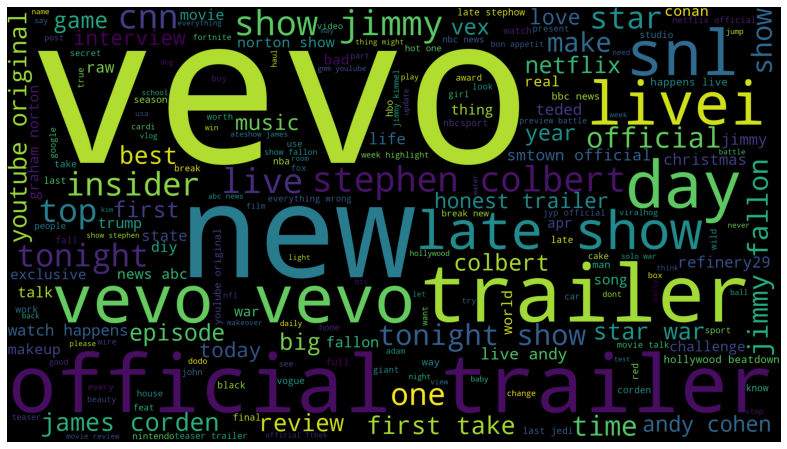

In [44]:
import re

df.loc[:, "clean_thumb_ocr_text_V2"] = df.loc[:, "clean_thumb_ocr_text_V2"].fillna('')
all_words = ' '.join(df.loc[:, "clean_thumb_ocr_text_V2"].values)
all_words = re.sub(' +', ' ', all_words)

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1920, height=1080).generate(all_words)
figure(figsize=(16, 8))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Wizualizacja statystyk liczbowych

IndexError: list index out of range

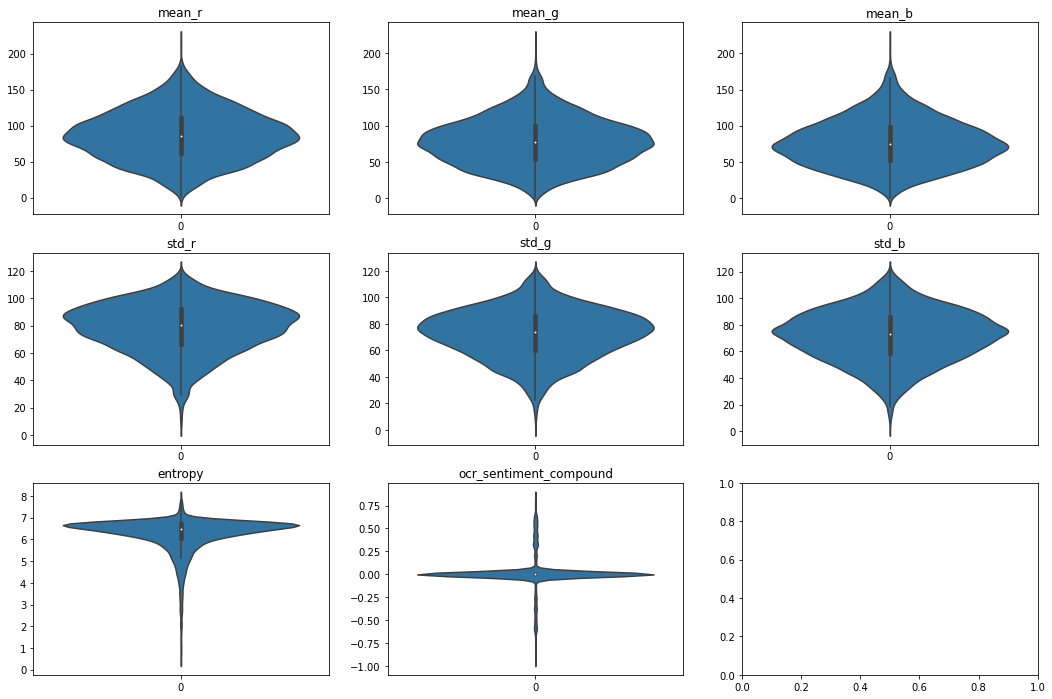

In [29]:
import math

list_of_columns = [
    'mean_r', 'mean_g', 'mean_b',
    'std_r', 'std_g', 'std_b', 
    'entropy', 
    'ocr_sentiment_compound'
]
n_of_cols = 3
n_of_rows = int(math.ceil(len(list_of_columns)/n_of_cols))
fig, axes = plt.subplots(n_of_rows, n_of_cols, figsize=(n_of_cols*6, n_of_rows*4))

data = df.loc[:, list_of_columns]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.set_title(list_of_columns[i*n_of_cols+j])
        sns.violinplot(ax=ax,data=df.loc[:, list_of_columns[i*n_of_cols+j]])

### Utworzenie wektora cech z ResNet18

In [43]:
%%time
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image


# Odkomentować zapis jeśli trzeba!!!
imgs_path = Path(f'./../../data/thumbnailsHQ/')

# # Load the pretrained model
model = models.resnet18(pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


for i, img_path in enumerate(glob.glob(f"./../..data/thumbnailsHQ/GB/*.png") + glob.glob(f"./../..data/thumbnailsHQ/US/*.png")): 
    path = Path(img_path)
    imgPIL = Image.open(path)
    
    input_tensor = preprocess(imgPIL)
    input_batch = input_tensor.unsqueeze(0)
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    features_vector = torch.zeros(512)
    def copy_data(module, input_, output):
        features_vector.copy_(output.data.flatten())
        
    h = layer.register_forward_hook(copy_data)
    
    with torch.no_grad():
        output = model(input_batch)

    df.loc[df.video_id == path.stem, "features_vec_resnet18"] = json.dumps(features_vector.tolist())    

    if (i % 100 == 0):
        print(i, end='\r')


df.to_csv(f"./../../our_data/Etap2/lilatee/GB_US-07_ResNet.csv", index=False)
df[:5]

CPU times: user 33min 26s, sys: 4min 21s, total: 37min 47s
Wall time: 40min 39s


,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,features_vec_resnet18
0,Jw1Y-zhQURU,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.000000,0.0,NaN
1,3s1rvMFUweQ,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.000000,0.0,NaN
2,n1WpP7iowLc,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,GB,66.502830,71.743704,79.699635,83.992492,83.883918,83.748135,"[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...","[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...","[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...",6.470819,\n,NaN,wigy water an vevo,wigy water vevo,"[""[[25, 118], [173, 194]]"", ""[[282, 116], [468...","[177.0, 202.33333333333334]",177.0,202.333333,0.0,"[0.24609655141830444, 2.066065788269043, 4.700..."
3,PUTEiSjKwJU,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,GB,86.534334,73.284271,69.150666,78.330501,71.675730,68.933206,"[38491, 1841, 1874, 1096, 801, 658, 612, 594, ...","[38491, 1841, 1874, 1096, 801, 658, 612, 594, ...","[38491, 1841, 1874, 1096, 801, 658, 612, 594, ...",6.839139,\n\ney tderr ott\n\nSTE a CLASS OF 92\n...,class,3 10 3 92 salford city class of 92 4 dudley2n ...,salford city class dudley2n dieseruvwe webbers...,"[""[[127, 260], [173, 277]]"", ""[[174, 262], [19...","[219.6, 284.9]",219.6,284.900000,0.0,"[0.08890726417303085, 0.28475505113601685, 0.4..."
4,rHwDegptbI4,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.000000,0.0,NaN


### PCA

/home/lilatee/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


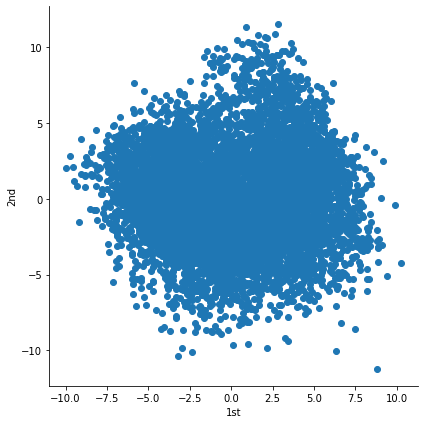

In [3]:
from sklearn import decomposition

df = pd.read_csv(f"./../../our_data/Etap2/lilatee/GB_US-07_ResNet.csv")
list_of_vecs = df.loc[df.features_vec_resnet18.notnull(), "features_vec_resnet18"].values
list_of_vecs = list(map(json.loads, list_of_vecs))

pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(list_of_vecs)
pca_df = pd.DataFrame(pca_data, columns=["1st", "2nd"])
sns.FacetGrid(pca_df, size=6).map(plt.scatter, "1st", "2nd")

### Połączenie wyników z Etapem 1

In [5]:
import pandas as pd
region = 'GB_US'
df_1 = pd.read_csv(f"./../../our_data/Etap1/{region}.csv")
df_2 = pd.read_csv(f"./../../our_data/Etap2/lilatee/{region}-07_ResNet.csv")
print(df_1.shape)
print(df_2.shape)

(8509, 69)
(8509, 23)


In [6]:
df_1[:3]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_list_of_urls,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"[""christmas"", ""john lewis christmas"", ""john le...",7224515,55681,10247,...,608,0.740560,9,0.085262,"[""http://bit.ly/2mboXgj"", ""http://bit.ly/2hg04...",7,0,True,True,True
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"[""SNL"", ""Saturday Night Live"", ""SNL Season 43""...",1053632,25561,2294,...,276,0.661871,18,0.167866,"[""http://www.nbc.com/saturday"", ""http://www.nb...",7,0,True,True,True
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"[""Eminem"", ""Walk"", ""On"", ""Water"", ""Aftermath/S...",17158579,787420,43420,...,433,0.728956,9,0.158249,"[""http://shady.sr/WOWEminem"", ""https://goo.gl/...",14,0,True,True,True


In [7]:
df_2[:3]

,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,...,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,features_vec_resnet18
0,Jw1Y-zhQURU,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.000000,0.0,NaN
1,3s1rvMFUweQ,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.000000,0.0,NaN
2,n1WpP7iowLc,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,GB,66.50283,71.743704,79.699635,83.992492,83.883918,83.748135,"[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...",...,\n,NaN,wigy water an vevo,wigy water vevo,"[""[[25, 118], [173, 194]]"", ""[[282, 116], [468...","[177.0, 202.33333333333334]",177.0,202.333333,0.0,"[0.24609655141830444, 2.066065788269043, 4.700..."


In [8]:
df_result = pd.concat([df_1.set_index(df_1.video_id), df_2.set_index(df_2.video_id).iloc[:, 2:]], axis=1)
df_result.to_csv(f"./../../our_data/Etap2/{region}-Etap2.csv", index=False)
df_result[:3]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,features_vec_resnet18
video_id,,,,,,,,,,,,,,,,,,,,,
Jw1Y-zhQURU,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"[""christmas"", ""john lewis christmas"", ""john le...",7224515,55681,10247,...,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.000000,0.0,NaN
3s1rvMFUweQ,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"[""SNL"", ""Saturday Night Live"", ""SNL Season 43""...",1053632,25561,2294,...,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.000000,0.0,NaN
n1WpP7iowLc,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"[""Eminem"", ""Walk"", ""On"", ""Water"", ""Aftermath/S...",17158579,787420,43420,...,\n,NaN,wigy water an vevo,wigy water vevo,"[""[[25, 118], [173, 194]]"", ""[[282, 116], [468...","[177.0, 202.33333333333334]",177.0,202.333333,0.0,"[0.24609655141830444, 2.066065788269043, 4.700..."
